In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [82]:
class DNN:
    X_train = None
    Y_train = None
    X_test = None
    Y_test = None
    
    layer_dimensions = []
    activation_functions = []
    n_layers = 0
    possible_activations = set(["relu", "tanh", "sigmoid"])
    update_params = None
    
    
    def __init__(self, X_train, Y_train, X_test, Y_test):
        """
            arguments:
                X_train -> training data
                Y_train -> true output of the training data
                X_test -> test data
                Y_test -> true output of the test data
        """
        self.X_train = X_train
        self.Y_train = Y_train
        
        self.X_test = X_test
        self.Y_test = Y_test

        # Adding the dimensions of the input layer
        self.layer_dimensions = [X_train.shape[0]]
        self.activation_functions = []
        
    def add_layer(self, n_hidden, activation_function):
        """
            arguments:
                n_hidden -> number of hidden units in the current layer
                activation_function -> activation function of the current layer
        """
        assert activation_function in self.possible_activations, "invalid activation function"
        self.layer_dimensions.append(n_hidden)
        self.activation_functions.append(activation_function)
        
    def fit(
        self, number_iterations = 2500, learning_rate = 0.0001, _lambda=1, optimization_algo="default", check_grad=False
    ):
        """
        arguments:
            X, Y -> training-set
            layer_dimensions -> python list: index i = layer_dimension ith layer
            activation_functions -> python list: index i = activation ith layer
            number_iterations -> how many times you want gradient descent to run
            learning_rate -> the amount you want the parameters to be affected by the gradient update
            _lambda -> regularization parameter
            optimization_algo -> optimization algorithm that will be used to update the parameters
            check_grad -> use gradient check during training to debug
        return:
            params -> updated params after all iterations
            costs -> python list containing cost during training
        """
        self.n_layers = len(self.activation_functions)
        params = self.initialize_params()
        self.update_params = UpdateParams(self.n_layers)
        costs = []
        for i in range(number_iterations + 1):
            Al, caches = self.forward_propagation(self.X_train, params)
            grads = self._backward_propagation(Al, caches, _lambda)

            # Debug gradients
            if check_grad:
                self._gradient_check(params, grads, self.X_train, self.Y_train, _lambda)
            
            params = self.update_params.update(params, grads, learning_rate, optimization_algo)
            cost = self.cost_function(Al, self.Y_train, params, _lambda)
            costs.append(cost)
            if (i % 100) == 0 or (i == number_iterations):
                print(f"Cost at iteration {i} is: {cost}")
    
        return params, costs

    def initialize_params(self):
        """
        arguments:
            layer_dimensions -> python list, index i = layer i
        return:
            params -> python dict: ("Wl") = matrix; ("Bl") = vector
        """
        params = {}
        for l in range(1, self.n_layers + 1):
            n_input = self.layer_dimensions[l - 1]
            n_hidden = self.layer_dimensions[l]
            Wl = np.random.randn(n_hidden, n_input) * np.sqrt(2.0 / n_input)
            bl = np.zeros((n_hidden, 1))
            params["W" + str(l)] = Wl
            params["b" + str(l)] = bl
    
            # Making sure the dimensions are right
            assert(Wl.shape == (n_hidden, n_input))
            assert(bl.shape == (n_hidden, 1))

        return params
    
    def forward_propagation(self, X, params):
        """
        arguments:
            params -> python dict: ("Wl") = matrix; ("Bl") = vector
        return:
            A -> output for the Lth layer
            caches -> will be used to compute backpropagation: (linear_cache, Z) for index i
        """
        A = X
        caches = []

        # Making sure the input is of the correct size
        assert(self.n_layers == len(self.activation_functions))

        for l in range(self.n_layers):
            A_prev = A
            W = params["W" + str(l + 1)]
            b = params["b" + str(l + 1)]
            activation_function = self.activation_functions[l]
            A, cache = self._forward_propagation_single_layer(A_prev, W, b, activation_function)
            caches.append(cache)

        return A, caches

    def _forward_propagation_single_layer(self, A_prev, W, b, activation_function):
        """
        arguments:
            A_prev -> input from the previous layer
            W, b -> params of the current layer
            activation_function -> activation function for the current layer ("sigmoid", "relu")
        return:
            A -> output from the current layer
            cache -> will be used to compute backpropagation: (linear_cache, Z)
        """
        Z, linear_cache = self._linear_function(A_prev, W, b)
        A = self._apply_activation_function(Z, activation_function)
        cache = (linear_cache, Z)
        return A, cache

    def _linear_function(self, A_prev, W, b):
        """
        arguments:
            A_prev -> input from the previous layer
            W, b -> params of the current layer
        return:
            Z -> matrix of shape: (n_hidden_layers, n_training_examples)
            cache -> will be used to compute backpropagation: (A_prev, W, b)
        """
        Z = np.matmul(W, A_prev) + b
        cache = (A_prev, W, b)
        return Z, cache

    def _apply_activation_function(self, Z, activation_function):
        """
        arguments:
            Z -> linear output from the current layer
            activation_function -> activation function for the current layer ("sigmoid", "relu")
        """
        if activation_function == "sigmoid":
            A = 1 / (1 + np.exp(np.clip(-Z, -30, 30)))
        elif activation_function == "relu":
            A = np.maximum(0, Z)
        elif activation_function == "tanh":
            A = np.tanh(Z)

        return A

    def _backward_propagation(self, AL, caches, _lambda):
        """
        arguments:
            AL(Y_hat) -> output for the Lth layer
            Y -> true output from the dataset
            caches -> will be used to compute the gradients: (linear_cache, Z) for index i
        return:
            grads -> gradients for each layer parameter
        """
        grads = {}
        m = AL.shape[1]

        assert(self.n_layers == len(caches))
        assert(AL.shape == self.Y_train.shape)

        # Computing the gradients for the Lth layer to start out backward propagation
        cache = caches[self.n_layers - 1]
        linear_cache, Z = cache
        _, W, _ = linear_cache
        activation_function = self.activation_functions[self.n_layers - 1]

        dAL = - np.divide(self.Y_train, AL) + np.divide(1 - self.Y_train, 1 - AL)
        dA_prev, dW, db = self._backward_propagation_single_layer(dAL, cache, activation_function)
        dW += (_lambda / m) * W

        grads["dA" + str(self.n_layers - 1)] = dA_prev
        grads["dW" + str(self.n_layers)] = dW
        grads["db" + str(self.n_layers)] = db

        for l in reversed(range(self.n_layers - 1)):
            cache = caches[l]
            linear_cache, Z = cache
            _, W, _ = linear_cache
            activation_function = self.activation_functions[l]

            dA = grads["dA" + str(l + 1)]
            dA_prev, dW, db = self._backward_propagation_single_layer(dA, cache, activation_function)
            reg_term = (_lambda / m) * W
            dW += reg_term

            grads["dA" + str(l)] = dA_prev
            grads["dW" + str(l + 1)] = dW
            grads["db" + str(l + 1)] = db

        return grads

    def _backward_propagation_single_layer(self, dA, cache, activation_function):
        """
        arguments:
            dA -> derivative of the cost with respect to the activation output
            cache -> (linear_cache, Z)
            activation_function -> activation function for the current layer ("sigmoid", "relu")
        return:
            dA_prev, dW, db -> derivative of the cost with respect to the following
        """
        linear_cache, Z = cache
        dZ = self._activation_backward(dA, Z, activation_function)
        dA_prev, dW, db = self._linear_backward(dZ, linear_cache)
        return dA_prev, dW, db

    def _activation_backward(self, dA, Z, activation_function):
        """
        arguments:
            dA -> derivative of the cost function with respect to A(l)
            Z -> linear output of the current layer
            activation_function -> activation function for the current layer ("sigmoid", "relu")
        return:
            dZ -> derivative of the cost function with respect to Z(l)
        """
        A = self._apply_activation_function(Z, activation_function)
        if activation_function == "sigmoid":
            dZ = dA * A * (1 - A)
        elif activation_function == "relu":
            dZ = np.array(dA, copy=True)
            dZ[Z <= 0] = 0
        elif activation_function == "tanh":
            dZ = dA * (1 - np.square(A))

        return dZ

    def _linear_backward(self, dZ, linear_cache):
        """
        arguments:
            dZ -> derivative of the cost function with respect to Z(l)
            linear_cache -> (A_prev, W, b)
        return:
            dA_prev, dW, db -> derivatives of the cost function with respect to each one
        """
        A_prev, W, b = linear_cache
        num_neurons_current_layer, num_examples = dZ.shape
        num_neurons_prev_layer = A_prev.shape[0]

        # Calculate the gradients
        dA_prev = np.matmul(W.T, dZ)
        dW = (1 / num_examples) * np.matmul(dZ, A_prev.T)
        db = (1 / num_examples) * np.sum(dZ, axis=1).reshape(-1, 1)

        # Making sure the dimensions are right
        assert(dA_prev.shape == (num_neurons_prev_layer, num_examples))
        assert(dW.shape == (num_neurons_current_layer, num_neurons_prev_layer))
        assert(db.shape == (num_neurons_current_layer, 1))

        return dA_prev, dW, db

    def cost_function(self, Al, Y, params, _lambda):
        m = Y.shape[1]
        loss = Y * np.log(Al) + (1 - Y) * np.log(1 - Al)
        cost = (-1 / m) * np.sum(loss)
    
        # Compute regularization term
        L2_regularization_term = 0
        for key in params.keys():
            if 'W' in key:
                L2_regularization_term += np.sum(np.square(params[key]))
    
        cost += (_lambda / (2 * m)) * L2_regularization_term
        return cost

    def evaluate(self, AL, Y):
        n = Y.shape[1]
        AL_binary = [0] * n
        for i in range(n):
            if AL[0][i] > 0.5:
                AL_binary[i] = 1
            else:
                AL_binary[i] = 0
                
        correct_pred = np.equal(AL_binary, Y)
        correct = 0
        for i in range(n):
            correct += correct_pred[0][i]
        
        correct_percentage = (correct / n) * 100
        return correct_percentage


    # Used to debug the gradient computation
    def _gradient_check(self, parameters, gradients, X, Y, _lambda, epsilon=1e-7):
        """
        Checks if backward propagation computes the correct gradient for each parameter.
        
        Arguments:
        parameters -- dictionary containing the parameters "W1", "b1", ..., "WL", "bL"
        gradients -- dictionary containing the gradients computed by backprop
        X -- input data of shape (input size, number of examples)
        Y -- true "label"
        epsilon -- tiny shift to the input to compute approximated gradient
    
        Returns:
        difference -- relative difference between the approximated gradient and the backprop gradient
        """
        gradapprox = {}
        for key in parameters.keys():
            gradapprox["d" + key] = np.zeros_like(parameters[key])
            # Loop through each element of the parameter matrix
            for i in range(parameters[key].shape[0]):
                for j in range(parameters[key].shape[1]):
                    # Compute J_plus by slightly increasing the parameter
                    parameters[key][i, j] += epsilon
                    AL, _ = self.forward_propagation(X, parameters)
                    J_plus = self.cost_function(AL, Y, parameters, _lambda)
                    
                    # Compute J_minus by slightly decreasing the parameter
                    parameters[key][i, j] -= 2 * epsilon
                    AL, _ = self.forward_propagation(X, parameters)
                    J_minus = self.cost_function(AL, Y, parameters, _lambda)
                    
                    # Reset the parameter value
                    parameters[key][i, j] += epsilon
                    
                    # Compute the gradient approximation
                    gradapprox["d" + key][i, j] = (J_plus - J_minus) / (2 * epsilon)
        
        # Compute the relative difference between computed gradients and gradapprox
        numerator = 0
        denominator = 0

        for key in gradients.keys():
            # Skip keys that are not relevant for the gradient check
            if 'dA' in key:
                continue
            numerator += np.linalg.norm(gradients[key] - gradapprox[key])
            denominator += np.linalg.norm(gradients[key]) + np.linalg.norm(gradapprox[key])
        
        difference = numerator / denominator
  
        if difference > 2e-7:
            print(f"There is a mistake in the backward propagation! difference = {difference}")
        
        return difference


In [130]:
class UpdateParams:
    grads_momentum = {}
    grads_rms_prop = {}
    n_layers = 0

    def __init__(self, n_l):
        """
            arguments:
                n_l -> number of layers of the neural network
        """
        self.n_layers = n_l
        for l in range(1, self.n_layers + 1):
            self.grads_momentum["dW" + str(l)] = 0
            self.grads_momentum["db" + str(l)] = 0

            self.grads_rms_prop["dW" + str(l)] = 0
            self.grads_rms_prop["db" + str(l)] = 0

    def update(self, params, grads, learning_rate, optimization_algo, beta=0.9, beta1=0.9, beta2=0.999):
        self.n_layers = len(params) // 2
        if optimization_algo == "default":
            params = self._default(params, grads, learning_rate)
        elif optimization_algo == "momentum":
            params = self._momentum(params, grads, learning_rate, beta)
        elif optimization_algo == "rms_prop":
            params = self._rms_prop(params, grads, learning_rate, beta)
        elif optimization_algo == "adam":
            params = self._adam(params, grads, learning_rate, beta1, beta2)
        elif optimization_algo == "adopt":
            params = self._adopt(params, grads, learning_rate, beta1, beta2=0.9999)

        return params

    def _default(self, params, grads, learning_rate):
        
        for l in range(1, self.n_layers + 1):
            params["W" + str(l)] -= learning_rate * grads["dW" + str(l)]
            params["b" + str(l)] -= learning_rate * grads["db" + str(l)]

        return params

    def _momentum(self, params, grads, learning_rate, beta):
        
        for l in range(1, self.n_layers + 1):
            mW = (beta * self.grads_momentum["dW" + str(l)]) + (1 - beta) * grads["dW" + str(l)]
            mb = (beta * self.grads_momentum["db" + str(l)]) + (1 - beta) * grads["db" + str(l)]
            
            params["W" + str(l)] -= learning_rate * mW
            params["b" + str(l)] -= learning_rate * mb
            
            self.grads_momentum["dW" + str(l)] = mW
            self.grads_momentum["db" + str(l)] = mb
            
        return params

    def _rms_prop(self, params, grads, learning_rate, beta):
        
        epsilon = 1e-8
        
        for l in range(1, self.n_layers + 1):
            rW = (beta * self.grads_rms_prop["dW" + str(l)]) + (1 - beta) * np.square(grads["dW" + str(l)])
            rb = (beta * self.grads_rms_prop["db" + str(l)]) + (1 - beta) * np.square(grads["db" + str(l)])
            
            params["W" + str(l)] -= learning_rate * (grads["dW" + str(l)] / np.sqrt(rW + epsilon))
            params["b" + str(l)] -= learning_rate * (grads["db" + str(l)] / np.sqrt(rb + epsilon))

            self.grads_rms_prop["dW" + str(l)] = rW
            self.grads_rms_prop["db" + str(l)] = rb

        return params

    def _adam(self, params, grads, learning_rate, beta1, beta2):
        
        epsilon = 1e-8
        
        for l in range(1, self.n_layers + 1):
            mW = (beta1 * self.grads_momentum["dW" + str(l)]) + (1 - beta1) * grads["dW" + str(l)]
            mb = (beta1 * self.grads_momentum["db" + str(l)]) + (1 - beta1) * grads["db" + str(l)]
            
            rW = (beta2 * self.grads_rms_prop["dW" + str(l)]) + (1 - beta2) * np.square(grads["dW" + str(l)])
            rb = (beta2 * self.grads_rms_prop["db" + str(l)]) + (1 - beta2) * np.square(grads["db" + str(l)])

            params["W" + str(l)] -= learning_rate * (mW / np.sqrt(rW + epsilon))
            params["b" + str(l)] -= learning_rate * (mb / np.sqrt(rb + epsilon))

            self.grads_momentum["dW" + str(l)] = mW
            self.grads_momentum["db" + str(l)] = mb
            
            self.grads_rms_prop["dW" + str(l)] = rW
            self.grads_rms_prop["db" + str(l)] = rb

        return params

    def _adopt(self, params, grads, learning_rate, beta1, beta2):

        epsilon = 1e-6
        
        for l in range(1, self.n_layers + 1):
            mW = (beta1 * self.grads_momentum["dW" + str(l)]) + (1 - beta1) * (grads["dW" + str(l)] / np.sqrt(self.grads_rms_prop["dW" + str(l)] + epsilon))
            mb = (beta1 * self.grads_momentum["db" + str(l)]) + (1 - beta1) * (grads["db" + str(l)] / np.sqrt(self.grads_rms_prop["db" + str(l)] + epsilon))

            rW = (beta2 * self.grads_rms_prop["dW" + str(l)]) + (1 - beta2) * np.square(grads["dW" + str(l)])
            rb = (beta2 * self.grads_rms_prop["db" + str(l)]) + (1 - beta2) * np.square(grads["db" + str(l)])
                                                                                        
            params["W" + str(l)] -= learning_rate * mW
            params["b" + str(l)] -= learning_rate * mb

            self.grads_momentum["dW" + str(l)] = mW
            self.grads_momentum["db" + str(l)] = mb
            
            self.grads_rms_prop["dW" + str(l)] = rW
            self.grads_rms_prop["db" + str(l)] = rb

        return params

In [131]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# Generate a synthetic binary classification dataset
X, Y = make_moons(n_samples=1000, noise=0.2, random_state=1)

# Split into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

# Adjusting the dimensions
X_train = X_train.T
X_test = X_test.T
Y_train = Y_train.reshape(1, -1)
Y_test = Y_test.reshape(1, -1)

In [132]:
n_neurons_first_layer, n_training_examples = X_train.shape
n_neurons_output_layer = Y_train.shape[0]

In [133]:
model = DNN(X_train, Y_train, X_test, Y_test)

In [134]:
model.add_layer(20, "relu")
model.add_layer(7, "relu")
model.add_layer(5, "tanh")
model.add_layer(n_neurons_output_layer, "sigmoid")

In [148]:
np.random.seed(1)
parameters, costs = model.fit(
    number_iterations=300, learning_rate=0.001, _lambda=2, optimization_algo="adopt"
)

Cost at iteration 0 is: 1.0024186835439246
Cost at iteration 100 is: 0.2088453687165766
Cost at iteration 200 is: 0.14838134645493112
Cost at iteration 300 is: 0.13782375892085102


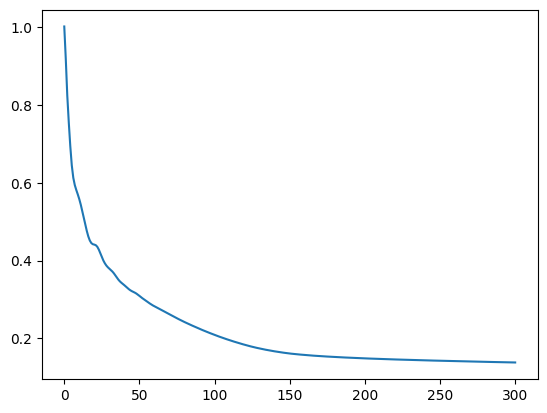

In [149]:
plt.plot(costs)

In [150]:
AL_train, caches = model.forward_propagation(X_train, parameters)
AL_test, caches = model.forward_propagation(X_test, parameters)
correct_train = model.evaluate(AL_train, Y_train)
correct_test = model.evaluate(AL_test, Y_test)
print("Percentage of correct predictions Training set: ", correct_train)
print("Percentage of correct predictions Test set", correct_test)

Percentage of correct predictions Training set:  97.5
Percentage of correct predictions Test set 95.0


## Conclusion
The model worked as expected, achieving a good accuracy in both the training set and the test set.